In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
    

# Dati Femminicidio  (hundred thousand inhabitants) EUROSTAT
# ( Dati bulgaria - belgio - denmark - Estonia da WAVE Country Report 2023)

# Gender equality index campi-> POWER(position among istitutions and company) , SEGREGATION (difference in edu field) , TIME (care activities,cooking,social activities)
# FRA survey 2012 questions: reason to not contacted services after violence, economic violence during life

#protection index:  presi dati su Wave country report 2023 su: numero aiuto nazionale, chiamate ricevute,
# n shelter, letti, n woman centers, presenza supporto violenza e piano prevenzione.
#Trasformati in dummy (per presenza/assenza) o rapportati alla popolazione per quelle numeriche.
# dati Poi normalizzati e calcolata la media semplice senza ponderazione.

df = pd.read_csv(r"feminicide_full.csv")
indicators= pd.read_csv(r"GEI_FRA_indicators.csv")

# riempire i NaN con la media del Paese
df['OBS_VALUE'] = df.groupby('geo')['OBS_VALUE'].transform(
    lambda x: x.fillna(x.mean().round(1))
)

df['TIME_PERIOD'] = df['TIME_PERIOD'].astype(str)
indicators['TIME_PERIOD']= indicators['TIME_PERIOD'].astype(str)
df.rename(columns={'OBS_VALUE': 'FEMINICIDE_100k'}, inplace=True)


df = df.loc[~df['TIME_PERIOD'].between('2008', '2014'), ['geo','TIME_PERIOD','FEMINICIDE_100k']]

init = df.merge(
    indicators[['geo', 'TIME_PERIOD', 'power','segregation','time','shame','useless','economic_violence']],
    on=['geo', 'TIME_PERIOD'],
    how='inner'
    )




In [2]:
#Funzione per preparare e unire i dataframe


def set_merge(df1,df2,col_name2):
    
    # riempire i NaN con la media del Paese
    df2['OBS_VALUE'] = df2.groupby('geo')['OBS_VALUE'].transform(
    lambda x: x.fillna(x.mean().round(1)))
    
    # date to string
    df2['TIME_PERIOD'] = df2['TIME_PERIOD'].astype(str)
    
    # merge nuovo dataframe
    new = df1.merge(
    df2[['geo', 'TIME_PERIOD', 'OBS_VALUE']].rename(columns={'OBS_VALUE': f'{col_name2}'}),
    on=['geo', 'TIME_PERIOD'],
    how='left'
    )
    
    return new
    

In [3]:
pay_gap = pd.read_csv(r"gender_pay_gap.csv")
div_rate= pd.read_csv(r"divorce_rate.csv")
edu= pd.read_csv(r"fem_ter_edu.csv")
fem_emp= pd.read_csv(r"female_emp.csv")
prot= pd.read_csv(r"protection_index.csv")
risk= pd.read_csv(r"fem_at_risk_of_poverty_exclusion.csv")
violence = pd.read_csv(r"physical_violence_any_perpetrator.csv")


# Merge in sequenza dei dataframe
a= set_merge(init,pay_gap,'PAY_GAP')
b= set_merge(a,div_rate,'DIVORCE_RATE')
c= set_merge(b,fem_emp,'FEMALE_EMPLOYMENT')
d= set_merge(c,edu,'%_FEM_TER_EDU')
e= set_merge(d,violence,'VIOLENCE')
f= set_merge(e,risk,'%_AT_RISK_POVERTY_EXCLUSION')
g= set_merge(f,prot,'protection_index')

In [ ]:

# ordina i valori decrescenti
df_sorted = g.sort_values(by='FEMINICIDE_100k', ascending=False)

sns.barplot(data=df_sorted, order=df_sorted['geo'],   x='FEMINICIDE_100k',y='geo', errorbar=None)

plt.show()

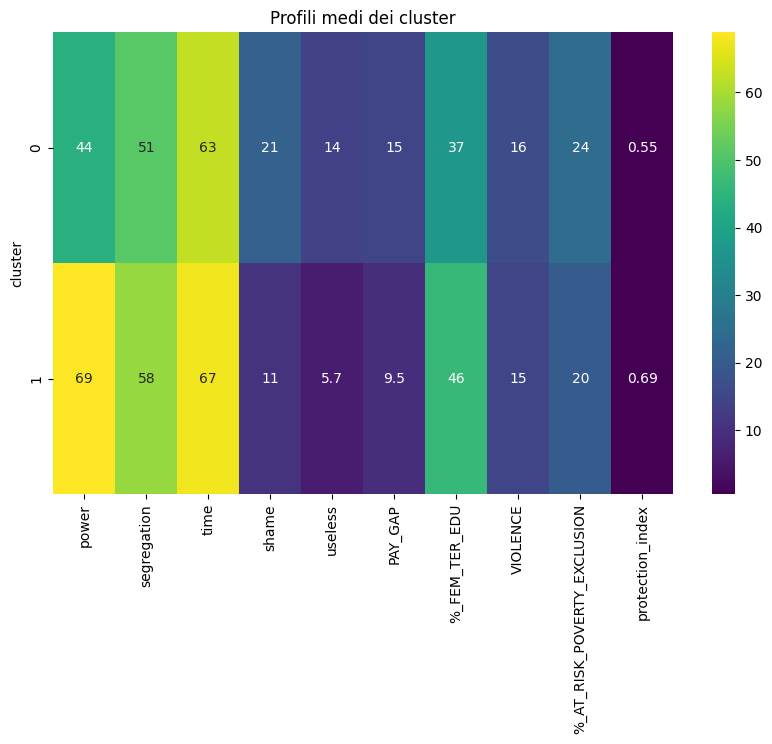

cluster
0    0.684583
1    0.371250
Name: FEMINICIDE_100k, dtype: float64

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X2 = g.drop(columns=['geo', 'TIME_PERIOD', 'FEMINICIDE_100k',
                     
                     'FEMALE_EMPLOYMENT','DIVORCE_RATE',
                     'economic_violence'
                    
                     ])  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X2)

kmeans = KMeans(n_clusters=2, random_state=42)
g['cluster'] = kmeans.fit_predict(X_scaled)

import seaborn as sns
import matplotlib.pyplot as plt

cluster_profile = g.groupby('cluster')[X2.columns].mean()

plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile, annot=True, cmap='viridis')
plt.title("Profili medi dei cluster")
plt.show()

g.groupby('cluster')['FEMINICIDE_100k'].mean().sort_values(ascending=False)



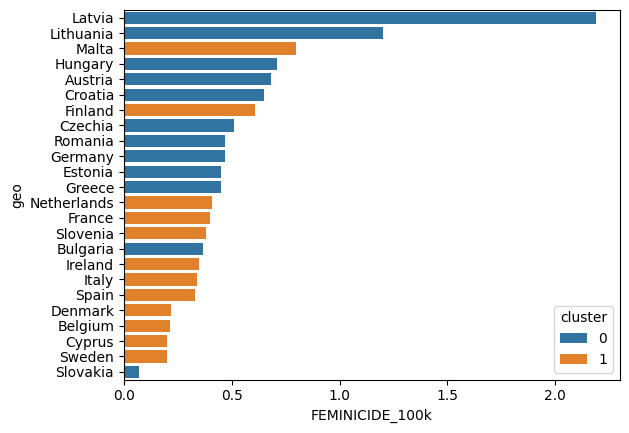

In [6]:

# ordina i valori decrescenti
df_sorted = g.sort_values(by='FEMINICIDE_100k', ascending=False)

sns.barplot(data=df_sorted, order=df_sorted['geo'],   x='FEMINICIDE_100k',y='geo', errorbar=None,hue='cluster',
    dodge=False)

plt.show()

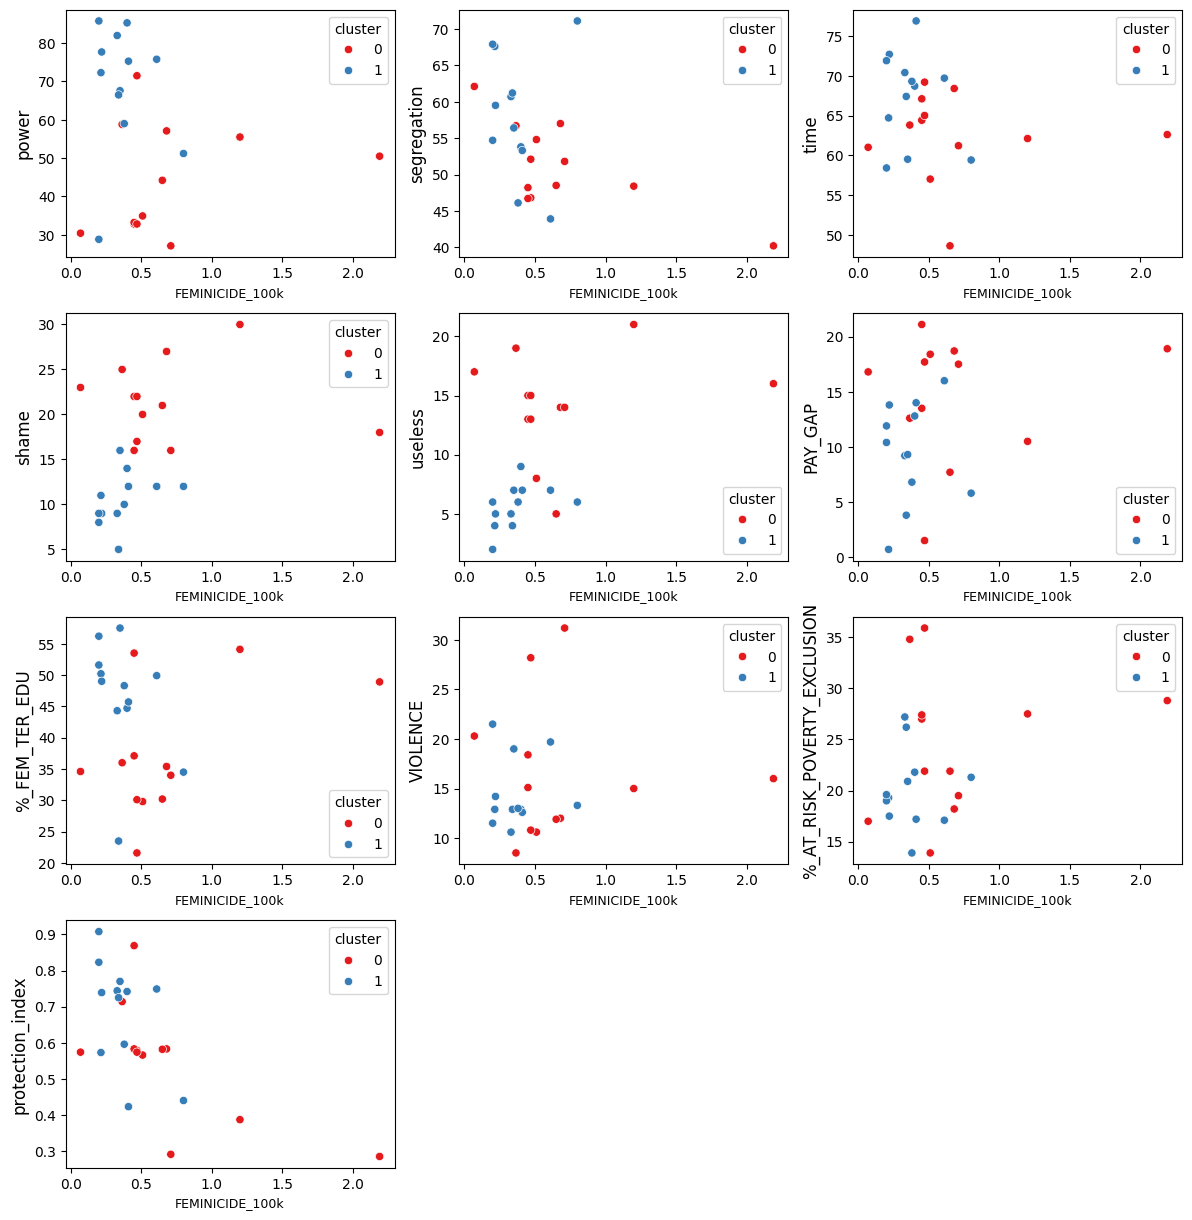

In [7]:
import math
variabili = g.drop(columns=['geo', 'TIME_PERIOD', 'FEMINICIDE_100k','cluster',
                            'FEMALE_EMPLOYMENT','economic_violence','DIVORCE_RATE'])



n = len(variabili)
cols = 3                               # numero colonne nella griglia (puoi cambiarlo)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

for i, var in enumerate(variabili):
    sns.scatterplot(
        x=g['FEMINICIDE_100k'], 
        y=g[var], 
        hue=g['cluster'], 
        palette="Set1", 
        ax=axes[i],
        legend=True
    )
    axes[i].set_xlabel('FEMINICIDE_100k',fontsize=9)
    axes[i].set_ylabel(var,fontsize=12)

# Rimuovi eventuali assi vuoti
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    


plt.tight_layout(pad=1)
plt.show()

In [97]:
import statsmodels.api as sm


df_ols = g.copy()


# VIOLENCE   FEMALE_EMPLOYMENT    %_FEM_TER_EDU 

X_ols = g[['protection_index','%_AT_RISK_POVERTY_EXCLUSION',
           'power','segregation','time','shame','useless',
           'PAY_GAP', 'DIVORCE_RATE','economic_violence']]
X_ols = sm.add_constant(X_ols)

# y = variabile dipendente
y_ols = g['FEMINICIDE_100k']


# Fit OLS
ols_model = sm.OLS(y_ols, X_ols)
ols_results = ols_model.fit()

print(ols_results.summary())

print(g.drop(columns=['geo','TIME_PERIOD','cluster']).corr())


                            OLS Regression Results                            
Dep. Variable:        FEMINICIDE_100k   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     4.229
Date:                Fri, 07 Nov 2025   Prob (F-statistic):            0.00879
Time:                        12:46:19   Log-Likelihood:                 4.2674
No. Observations:                  24   AIC:                             13.47
Df Residuals:                      13   BIC:                             26.42
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
# PLOT LINEARE
plot_vars = g.drop(columns=['geo', 'TIME_PERIOD', 'FEMINICIDE_100k','cluster'])
for var in plot_vars:

    plt.figure()

    sns.regplot(x=g['FEMINICIDE_100k'], y=var, data=g)
    plt.show()

In [8]:

X3= g.drop(columns=['geo','TIME_PERIOD','FEMINICIDE_100k','cluster',
                    'FEMALE_EMPLOYMENT','DIVORCE_RATE',
                     'economic_violence','VIOLENCE'
                   ])

In [9]:
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np


X = X3.values
y = g["cluster"].values

loo = LeaveOneOut()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=4,
    random_state=42
)

preds = []
true_vals = []
importances_list = []

for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)

    preds.append(pred[0])
    true_vals.append(y_test[0])
    importances_list.append(rf.feature_importances_)

# --- METRICHE ---
print("LOOCV Accuracy:", accuracy_score(true_vals, preds))
print("Confusion Matrix:\n", confusion_matrix(true_vals, preds))

# precision e recall SOLO per classe 0
print("Precision classe 0:", precision_score(true_vals, preds, labels=[0], average='macro'))
print("Recall classe 0:", recall_score(true_vals, preds, labels=[0], average='macro'))

# Media feature importance
mean_importances = np.mean(importances_list, axis=0)

# Ordiniamo in una serie leggibile
fi_series = pd.Series(mean_importances, index=X3.columns).sort_values(ascending=False)

print(fi_series)


LOOCV Accuracy: 1.0
Confusion Matrix:
 [[12  0]
 [ 0 12]]
Precision classe 0: 1.0
Recall classe 0: 1.0
shame                          0.323606
useless                        0.243716
power                          0.120110
protection_index               0.067677
PAY_GAP                        0.062569
%_FEM_TER_EDU                  0.051656
time                           0.051107
%_AT_RISK_POVERTY_EXCLUSION    0.040788
segregation                    0.038772
dtype: float64


In [10]:
from sklearn.metrics import silhouette_score
print("Silhouette:", silhouette_score(X_scaled, g['cluster']))


Silhouette: 0.25486674639864143
